In [1]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
from scipy.stats import zscore
from datetime import datetime
import xgboost as xgb
import antropy as ant
import scipy.signal as sp_sig
import scipy.stats as sp_stats
from sklearn.preprocessing import robust_scale
from visbrain.io.rw_hypno import read_hypno
from ipynb.fs.defs.yasa_model import calc_features, get_metrics, bandpower_from_psd_ndarray
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree
plt.style.use('dark_background')
pd.options.display.precision = 10

In [ ]:
# joblib_file = 'lgbm_model_multichannel.pkl'
# model = joblib.load('forest_full_7s.pkl')
#model = joblib.load('rf_thesis.pkl')
#features_names = pd.read_csv('features_thesis.csv').columns.tolist()
model = joblib.load('lgbm_fast.pkl')
features_names = pd.read_csv('features_fast.csv').columns.tolist()


In [3]:
####################
# MAIN PARAMETERS
####################

# # Bandpass filter
# freq_broad = (0.1, 500)
# # FFT & bandpower parameters
sr = 1000
# edf_path = 'C:\\UCLA\\P%s_full_filtered.edf'
edf_path = 'C:\\Users\\user\\PycharmProjects\\pythonProject\\%s_clean.edf'
# edf_path = 'C:\\UCLA\\P%s_overnightData.edf'
# bands = [
#     (0.1, 4, 'delta'), (4, 8, 'theta'),
#     (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
#     (30, 75, 'gamma'), (75, 300, 'fast')
# ]

In [4]:
def calc_features_fast(epochs, subj):
    # Bandpass filter
    freq_broad = (0.1, 500)
    # FFT & bandpower parameters
    sr = 1000
    bands = [
        (0.1, 4, 'delta'), (4, 8, 'theta'),
        (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
        (30, 100, 'gamma'), (100, 300, 'fast')
    ]

    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)

    feat = {
        'subj': np.full(len(epochs), subj),
        'epoch_id': np.arange(len(epochs)),
        'std': np.std(epochs, ddof=1, axis=1),
        'iqr': sp_stats.iqr(epochs, axis=1),
        'skew': sp_stats.skew(epochs, axis=1),
        'kurt': sp_stats.kurtosis(epochs, axis=1),
        'nzc': ant.num_zerocross(epochs, axis=1),
        'hmob': hmob,
        'hcomp': hcomp
    }

    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sr)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    feat['at'] = feat['alpha'] / feat['theta']
    feat['gt'] = feat['gamma'] / feat['theta']
    feat['ft'] = feat['fast'] / feat['theta']
    feat['ag'] = feat['gamma'] / feat['alpha']
    feat['af'] = feat['fast'] / feat['alpha']
    feat['sf'] = feat['sigma'] / feat['fast']
    feat['bf'] = feat['beta'] / feat['fast']
    feat['gf'] = feat['gamma'] / feat['fast']

    # Add total power
    idx_broad = np.logical_and(
        freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)

    # Calculate entropy and fractal dimension features
    feat['perm'] = np.apply_along_axis(
        ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat['higuchi'] = np.apply_along_axis(
        ant.higuchi_fd, axis=1, arr=epochs)
    feat['petrosian'] = ant.petrosian_fd(epochs, axis=1)

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    # feat.index.name = 'epoch'

    #############################
    # SMOOTHING & NORMALIZATION
    #############################
    roll1 = feat.rolling(window=1, center=True, min_periods=1, win_type='triang').mean()
    roll1[roll1.columns] = robust_scale(roll1, quantile_range=(5, 95))
    roll1 = roll1.iloc[:, 2:].add_suffix('_cmin_norm')

    roll3 = feat.rolling(window=3, center=True, min_periods=1, win_type='triang').mean()
    roll3[roll3.columns] = robust_scale(roll3, quantile_range=(5, 95))
    roll3 = roll3.iloc[:, 2:].add_suffix('_pmin_norm')

    # Add to current set of features
    feat = feat.join(roll1).join(roll3)
    # Remove cols of only zeros
    feat = feat.loc[:, (feat != 0).any(axis=0)]

    return feat

In [5]:
def remove_rem(raw, edf):
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)

    return nrem_raw

def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    # Normalization
    epochs = np.array(epochs)
    epochs_norm = (epochs - epochs.mean()) / epochs.std()
    return epochs_norm

def format_combine_channel(edf, chans=['PZ' ,'C3' ,'C4']):
    epochs = []
    window_size = int(sr / 4)

    raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
    raw = mne.channels.combine_channels(raw, {'avg': [0, 1, 2]}, method='mean')
    raw_data = raw.get_data()[0]

    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)

    # Normalization
    epochs = np.array(epochs)
    epochs_norm = (epochs - epochs.mean()) / epochs.std()
    return epochs_norm


In [6]:
def get_all_y_multi_channel(subjects=['38', '396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in subjects:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
                x = format_raw_night(edf_path % subj, channel)
                features = calc_features_fast(x, subj)
                for neighbor in neighbors[channel[0]]:
                    x_neighbor = format_raw_night(edf_path % subj, neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features_fast(x_neighbor, subj).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(features[features_names[1:]])

        if subj in ['38', '396']:
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(features[features_names[1:]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def get_all_y_multi_channel_side(side, subjects=['38', '396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    y_all = np.empty(0)
    for subj in subjects:
        channel = side + 'AH1'
        if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
            x = format_raw_night(edf_path % subj, channel)
            features = calc_features(x, subj)
            for neighbor in neighbors[channel[0]]:
                x_neighbor = format_raw_night(edf_path % subj, neighbor)
                prefix = neighbor.replace(channel[0], '')
                features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
                features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

            side1_y = model.predict(features[features_names[1:]])
            y_all = np.concatenate((y_all, side1_y))

    return y_all

def get_one_y_multi_channel_side(subj, side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    channel = side + 'AH1'
    if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
        x = format_raw_night(edf_path % subj, channel)
        features = calc_features(x, subj)
        for neighbor in neighbors[channel[0]]:
            x_neighbor = format_raw_night(edf_path % subj, neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        side1_y = model.predict(features[features_names[1:]])

    return side1_y

def get_all_feat_eog(eog_num, subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_raw_night(edf_path % subj, 'EOG' + eog_num)
        features = calc_features_fast(x, subj)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_by_chan(chan, subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_raw_night(edf_path % subj, chan)
        features = calc_features_fast(x, subj)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_scalp_channels(channels=['C3', 'C4', 'PZ'], subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        channel = channels[0]
        x = format_raw_night(edf_path % subj, channel)
        features = calc_features(x, subj)
        for neighbor in channels[1:]:
            x_neighbor = format_raw_night(edf_path % subj, neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_avg_channels(subjects=['38', '396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_combine_channel(edf_path % subj)
        features = calc_features_fast(x, subj)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

In [7]:
def plt_80(cls, feat, y, prob=0.8, stratify=False, over=False):
    if stratify:
        strat = pd.DataFrame()
        strat['y'] = list(map(str, y))
        strat['subj'] = list(feat['subj'])
        strat['stratify'] = strat[['y', 'subj']].apply(lambda x: ''.join(x), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=strat['stratify'], random_state=20)
    else:
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)

    if over:
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]

    f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')
    pred_details = {}

    for i, (key, classifier) in enumerate(cls.items()):
        y_pred = classifier.predict_proba(X_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                          recall: {1}""".format(precision, recall)
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

        curr_pred_details = pd.DataFrame(data=X_test, copy=True)
        curr_pred_details['pred'] = y_pred[1]
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    return pred_details

def plt_cls(feat, y, stratify=False, over=False):
    if stratify:
        strat = pd.DataFrame()
        strat['y'] = list(map(str, y))
        strat['subj'] = list(feat['subj'].astype(str))
        strat['stratify'] = strat[['y', 'subj']].apply(lambda x: ''.join(x), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=strat['stratify'], random_state=20)
    else:
        X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)

    if over:
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]

    classifiers_2_all = {
        "Random Forest": RandomForestClassifier(),
        "LGBM": LGBMClassifier(),
        # "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    }

    pred_details = {}
    f, axes = plt.subplots(1, len(classifiers_2_all), figsize=(10, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers_2_all.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                  recall: {1}""".format(precision, recall)
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')
        curr_pred_details = pd.DataFrame(data=X_test, copy=True)
        curr_pred_details['pred'] = y_pred
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    return classifiers_2_all, pred_details

In [8]:
feat_all_eog1 = joblib.load('feat_all_eog1.pkl')
feat_all_eog2 = joblib.load('feat_all_eog2.pkl')
feat_avg = joblib.load('feat_avg.pkl')
y_all_bi = joblib.load('y_all_bi.pkl')

In [9]:
feat_avg.reset_index(inplace=True, drop=True)
feat_all_eog1.reset_index(inplace=True, drop=True)
feat_all_eog2.reset_index(inplace=True, drop=True)
feat_eog2_avg = pd.concat([feat_avg, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog12_avg = pd.concat([feat_avg, feat_all_eog1.iloc[:, 2:].add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog1_avg = pd.concat([feat_avg, feat_all_eog1.iloc[:, 2:].add_suffix('_1')], axis=1)

In [8]:
# run all subj (~15min, 6 subj)
# TODO: check normalization in all!!!
y_all_bi = get_all_y_multi_channel(subjects=['396', '398', '402', '406', '415', '416'])
clear_output()

In [10]:
feat_avg = get_all_feat_avg_channels(subjects=['396', '398', '402', '406', '415', '416'])
feat_all_eog2 = get_all_feat_eog('2', subjects=['396', '398', '402', '406', '415', '416'])
clear_output()

In [9]:
# feat_c3 = get_all_feat_chan('C3')
# feat_c4 = get_all_feat_chan('C4')
# feat_all_eog1 = get_all_feat_eog('1', subjects=['396', '398', '402', '406', '415', '416'])
# clear_output()
y_all_bi.sum()

17771.0

In [10]:
feat_pz = get_all_feat_by_chan('PZ', subjects=['396', '398', '402', '406', '415', '416'])
feat_pz.reset_index(inplace=True, drop=True)
clear_output()
feat_all_eog2 = joblib.load('feat_all_eog2.pkl')
feat_eog2_pz = pd.concat([feat_all_eog2.iloc[:, 2:].add_suffix('_2'), feat_pz.iloc[:, 2:].add_suffix('_pz')], axis=1)

In [9]:
feat_c3 = get_all_feat_by_chan('C3', subjects=['396', '398', '402', '406', '415', '416'])
clear_output()
feat_c3.reset_index(inplace=True, drop=True)
feat_eog2_c3 = pd.concat([feat_all_eog2.iloc[:, 2:].add_suffix('_2'), feat_c3.iloc[:, 2:].add_suffix('_c3')], axis=1)

In [8]:
# joblib.dump(feat_all_eog1, 'feat_all_eog1.pkl')
# joblib.dump(feat_all_eog2, 'feat_all_eog2.pkl')
# joblib.dump(feat_avg, 'feat_avg.pkl')
# joblib.dump(y_all_bi, 'y_all_bi.pkl')

In [28]:
feat_all_eog12 = pd.concat([feat_all_eog1.iloc[:, 2:].add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

In [ ]:
# K-fold
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=4, test_size=0.25, random_state=None)
classifiers_all = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier()
}

feat_all_np = feat_eog2_avg.to_numpy()
precision_list = []
recall_list = []
pred_details = {}
f, axes = plt.subplots(4, len(classifiers_all), figsize=(10, 20), sharey='row')

# feat_eog2_c3_over, y_all_bi_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)

for j, (train_index, test_index) in enumerate(skf.split(feat_eog2_avg, y_all_bi)):
    X_train, X_test = feat_eog2_avg.iloc[train_index], feat_eog2_avg.iloc[test_index]
    y_train, y_test = y_all_bi[train_index], y_all_bi[test_index]
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]
    oversample = SMOTE()
    X_train_data, y_train = oversample.fit_resample(X_train_data, y_train)
    for i, (key, classifier) in enumerate(classifiers_all.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[j][i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                      recall: {1}""".format(precision, recall)
        axes[j][i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        precision_list.append(metrics['precision'])
        recall_list.append(metrics['recall'])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')
        curr_pred_details = pd.DataFrame(data=X_test, copy=True)
        curr_pred_details['pred'] = y_pred
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

precision_list_np = np.array(precision_list)
recall_list_np = np.array(recall_list)
plt.show()
rf_precision = np.sum(precision_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_precision = np.sum(precision_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
rf_recall = np.sum(recall_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_recall = np.sum(recall_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
print("Random forest precision: {0:.3f}".format(rf_precision))
print("Random forest recall: {0:.3f}".format(rf_recall))
print("LGBM precision: {0:.3f}".format(lgbm_precision))
print("LGBM recall: {0:.3f}".format(lgbm_recall))

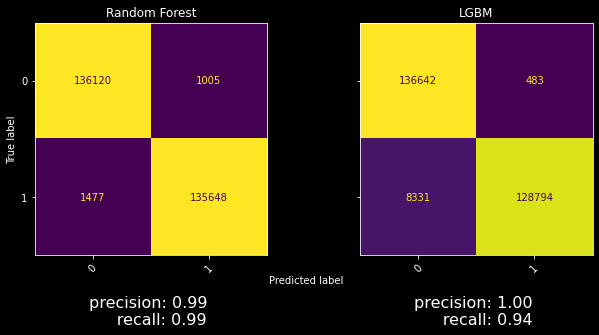

In [12]:
# overlapping / oversampling games
classifiers_overlap = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

f, axes = plt.subplots(1, len(classifiers_overlap), figsize=(10, 5), sharey='row')

oversample = SMOTE()
x_over, y_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, stratify=y_over, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

for i, (key, classifier) in enumerate(classifiers_overlap.items()):
    y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        y_lgbm = y_pred
    else:
        y_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

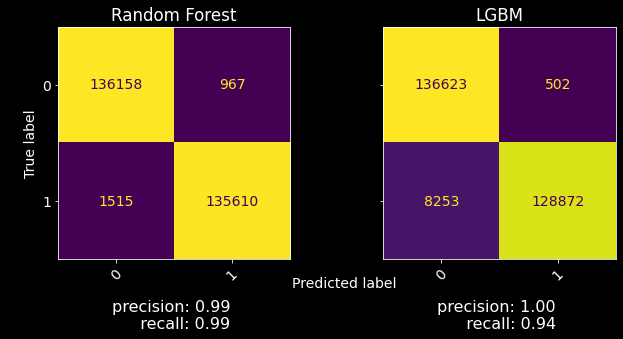

In [20]:
f, axes = plt.subplots(1, len(classifiers_overlap), figsize=(10, 5), sharey='row')
for i, (key, classifier) in enumerate(classifiers_overlap.items()):
    y_pred = classifier.predict_proba(X_test_data).T
    cf_matrix = confusion_matrix(y_test, [p >= 0.8 for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                          recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [ ]:
from datetime import datetime

print(datetime.now())

In [13]:
imp = pd.DataFrame(classifiers_overlap['LGBM'].feature_name_)
imp['imp'] = classifiers_overlap["Random Forest"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
66,nzc_cmin_norm_2,0.1023832014
16,nzc_cmin_norm,0.0730049698
85,nzc_pmin_norm_2,0.0392529222
3,nzc,0.0252581562
54,nzc_2,0.0235594364
79,abspow_cmin_norm_2,0.0223800208
97,abspow_pmin_norm_2,0.0179849675
12,abspow,0.0154875857
82,std_pmin_norm_2,0.0134982893
63,std_cmin_norm_2,0.0131831976


In [14]:
imp = pd.DataFrame(classifiers_overlap['LGBM'].feature_name_)
imp['imp'] = classifiers_overlap["LGBM"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
16,nzc_cmin_norm,593
66,nzc_cmin_norm_2,426
85,nzc_pmin_norm_2,267
3,nzc,144
54,nzc_2,102
79,abspow_cmin_norm_2,90
12,abspow,86
33,petrosian_cmin_norm,74
77,bf_cmin_norm_2,47
73,ft_cmin_norm_2,44


In [17]:
joblib.dump(classifiers_overlap, 'over_models.pkl')
joblib.dump({'X_train_data': X_train_data, 'y_train': y_train, 'X_test_data': X_test_data, 'y_test': y_test}, 'over_data.pkl')

['over_data.pkl']

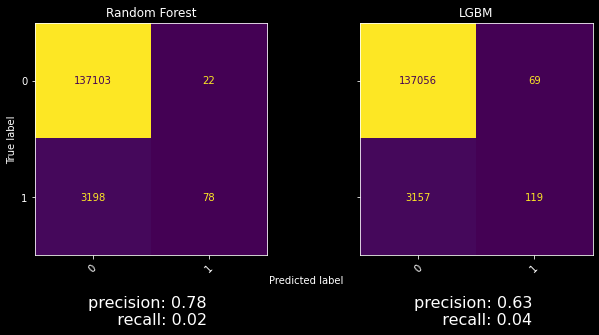

In [10]:
cls_all, pred_details = plt_cls(feat_eog2_avg, y_all_bi)

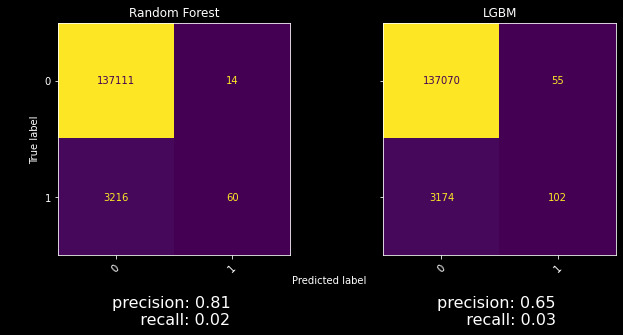

In [11]:
details_55 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.55)

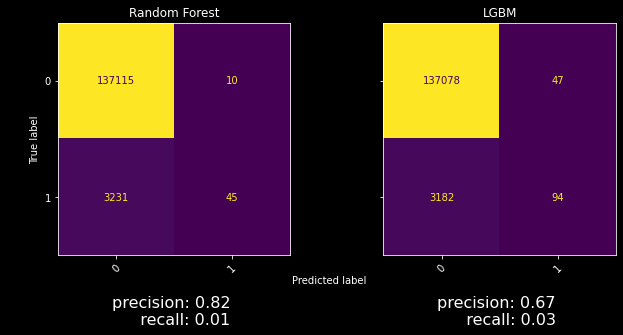

In [12]:
details_60 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.6)

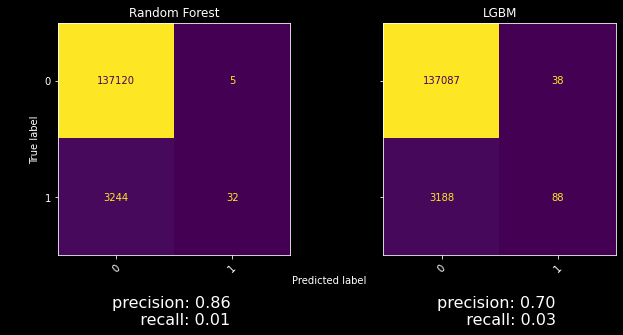

In [13]:
details_65 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.65)

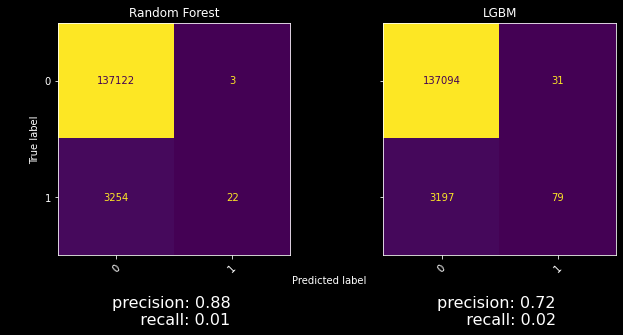

In [14]:
details_70 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.7)

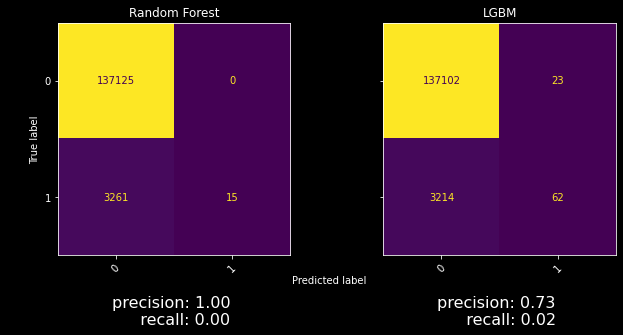

In [15]:
details_75 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.75)

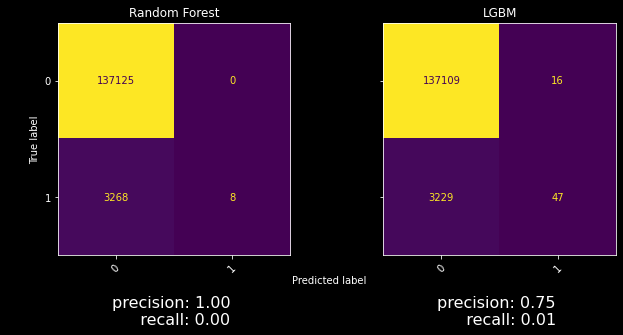

In [16]:
details_80 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.8)

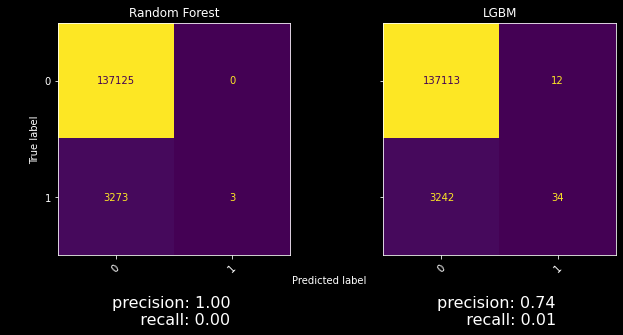

In [17]:
details_85 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.85)

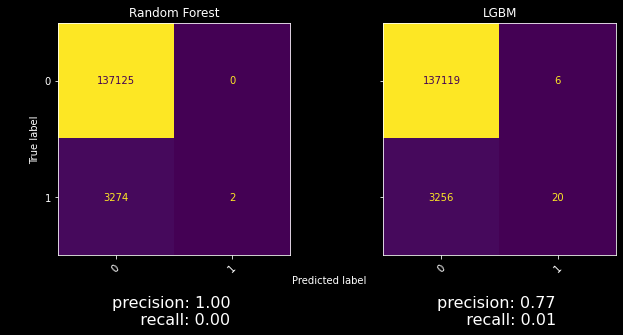

In [18]:
details_90 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.9)

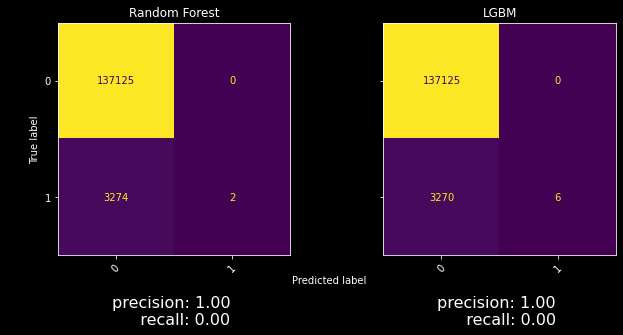

In [19]:
details_95 = plt_80(cls_all, feat_eog2_avg, y_all_bi,prob=0.95)

<AxesSubplot:>

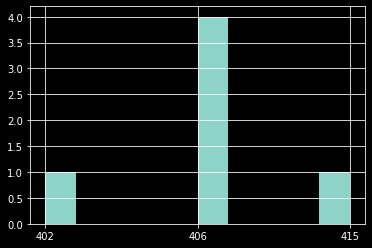

In [22]:
details = details_95['Random Forest']
details[(details['pred'] > 0.95)].sort_values(by='subj')['subj'].hist()

<AxesSubplot:>

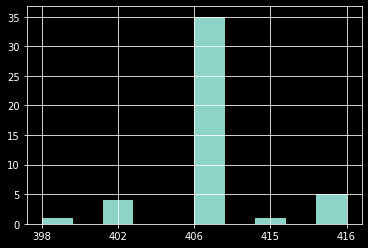

In [23]:
details = details_85['Random Forest']
details[(details['pred'] > 0.85)].sort_values(by='subj')['subj'].hist()

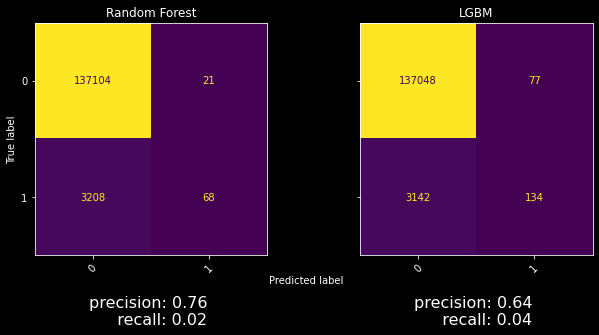

In [15]:
cls_all_12, pred_details_12 = plt_cls(feat_eog12_avg, y_all_bi)

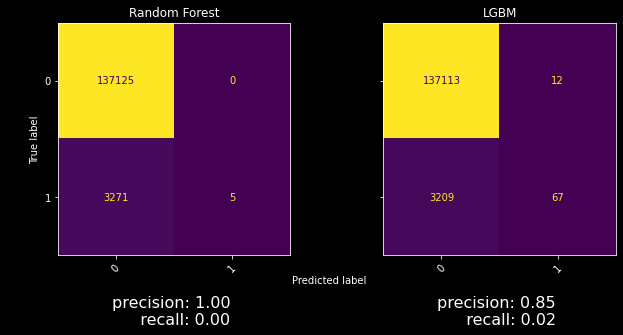

In [16]:
details_80 = plt_80(cls_all_12, feat_eog12_avg, y_all_bi, prob=0.80)

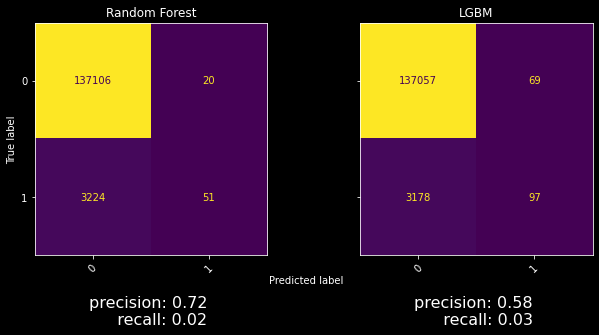

In [16]:
cls_all_strat, pred_details_strat = plt_cls(feat_eog2_avg, y_all_bi, stratify=True)

In [65]:
y_all_right = get_all_y_multi_channel_side('R')
y_all_left = get_all_y_multi_channel_side('L')
clear_output()

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

In [ ]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()

In [ ]:
# i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
# i_pred.sort()
# for i in i_pred[:20]:
#     fig, axs = plt.subplots(3, figsize=(4, 4))
#     axs[0].set_title(i)
#     pred_view = np.concatenate(x_AH[i - 2: i + 3])
#     axs[0].plot(pred_view)
#     axs[0].plot(range(500, 750), x_AH[i], c='red')
#     pred_view = np.concatenate(x_bi[i - 2: i + 3])
#     axs[2].plot(pred_view)
#     axs[2].plot(range(500, 750), x_bi[i], c='black')
#     pred_view = np.concatenate(x_A[i - 2: i + 3])
#     axs[1].plot(pred_view)
#     axs[1].plot(range(500, 750), x_A[i], c='green')

In [192]:
pred_details['Random Forest']

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,...,at_pmin_norm_2,gt_pmin_norm_2,ft_pmin_norm_2,ag_pmin_norm_2,af_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
23240,402,23240,0.0000061805,0.0000075643,0.9043173818,-0.3731787874,3,0.0423529503,4.2800305518,0.5429664511,...,0.2645690743,-0.0638160215,-0.1207882743,-0.0799799096,-0.1765310793,0.5403751808,-0.1934291748,-0.1128452484,-0.3068614195,0
3160,396,3160,0.0000015439,0.0000014184,1.2441867937,2.8720089154,1,0.0885457408,4.0280318501,0.2986484320,...,-0.1012437133,0.2246993063,0.2958636940,0.3112901272,0.3783851142,-0.1466988235,0.3952240036,0.2303743386,0.4255226684,0
66123,406,66123,0.0000113751,0.0000174620,0.6558363180,-0.9007563222,3,0.0466058011,2.9958969500,0.5193868697,...,0.3819044301,-0.0289513737,-0.0862293586,-0.0411525961,-0.0117236570,0.2800988129,0.0140576637,0.1340014094,0.0499600248,0
67080,406,67080,0.0000144562,0.0000265708,0.0766952076,-1.3312275436,3,0.0388921002,2.9789513262,0.6251846699,...,0.4051571890,-0.0369814968,0.3431210163,-0.0602406452,0.1373595454,-0.1384635840,0.5474291148,0.0633132832,0.6778949435,0
33942,416,33942,0.0000160657,0.0000257005,-0.7877683070,-0.8680450799,3,0.0372607046,2.4768767475,0.6232854062,...,-0.1516864810,0.3012074164,-0.0692659259,0.3760420507,-0.0496499390,0.2171681939,0.0304982949,-0.2225433291,-0.0136032034,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54993,416,54993,0.0000283590,0.0000575902,-0.2651708552,-1.5181737549,0,0.0321858028,2.5324087236,0.7895380142,...,-0.1960620407,-0.1117743548,-0.1378050342,-0.1161920907,-0.1534598601,0.5412905042,-0.2784039606,0.0985758979,-0.1745302021,0
11996,402,11996,0.0000064861,0.0000102593,-0.7229266879,-0.9711183663,4,0.0240940966,12.6296137546,0.8588380423,...,0.2507096879,0.5513401968,0.9792089970,0.2340487241,0.3945459644,0.4358849056,-0.0532248622,-0.1494672468,0.0919514509,0
40838,398,40838,0.0000063683,0.0000071969,1.0122663829,0.4029225544,3,0.0307351829,7.1365384256,0.6609515663,...,0.1455676836,0.0319967697,0.5084866915,-0.0059247001,0.2553098439,-0.0113539616,-0.1952777094,-0.1599477270,0.1573219860,0
69724,415,69724,0.0000177436,0.0000232742,0.2568682451,-0.3455045616,5,0.0544904173,1.6602074105,0.2939775346,...,0.2763069495,0.4486608213,-0.1435390011,0.1586304505,-0.1775994554,1.1745734530,-0.3772368067,-0.0324116335,-0.3827457981,0


In [51]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_all_scalp_eog = pd.concat([feat_all_eog_bi, feat_all_scalp.iloc[:, 2:]], axis=1)

In [ ]:
pred_epochs = pred_details[(pred_details['subj'] == '402') & (pred_details['pred'] ==1 )].epoch_id.tolist()
pred_epochs.sort()

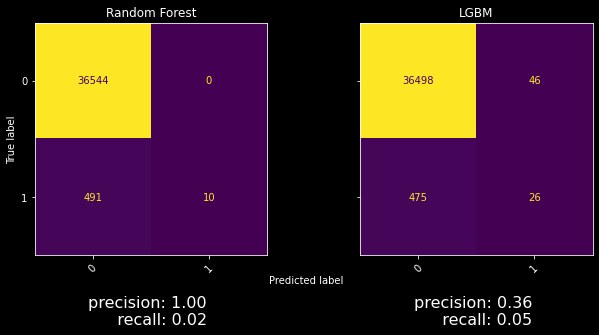

In [11]:
subj = '38'
y_bi_416 = get_all_y_multi_channel([subj])
# y_r = get_all_y_multi_channel_side('R', [subj])
# y_l = get_all_y_multi_channel_side('L', [subj])
feat_eog1_416 = get_all_feat_eog('1', [subj])
feat_eog2_416 = get_all_feat_eog('2', [subj])
feat_eog_bi_416 = pd.concat([feat_eog1_416.add_suffix('_1'), feat_eog2_416.add_suffix('_2')], axis=1)
clear_output()
cls_416_bi, pred_416 = plt_cls(feat_eog_bi_416, y_bi_416)

In [107]:
details = pred_details['Random Forest']
details[(details['pred'] ==1 )].sort_values(by='subj')[['subj', 'epoch_id']].to_csv('rf_filter_lgbm_scalp_avg_eog2_7.csv')

In [21]:
joblib.dump(pred_details, 'thesis_pred_details.pkl')

['thesis_pred_details.pkl']

In [10]:
pred_details = joblib.load('thesis_pred_details.pkl')

In [13]:
pred_details['Random Forest']

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,...,ag_pmin_norm_2,af_pmin_norm_2,sf_pmin_norm_2,bf_pmin_norm_2,gf_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
539732,416,85341,0.7157909531,1.3206209332,0.4141095836,-1.2614912931,0,0.0115763425,18.2740133604,1.2634007043,...,-0.0067107178,-0.0092469148,1.6593039126,0.0221773551,0.1504024372,0.6618443629,-0.8049939656,-0.5704268485,-0.3276902884,0.0
172465,402,5487,0.3300901192,0.5280611960,0.3940948567,-1.0919591982,3,0.0242223003,16.9173500821,0.8204919477,...,0.0046997826,-0.0020309933,0.1569180284,0.1158025400,0.0480720745,-0.1312160235,-0.0715512196,-0.0141656731,-0.0443214081,0.0
460008,416,5617,1.0770907100,1.4597722310,0.4265570741,-0.8056209101,2,0.0257825308,4.4772834172,0.9002726939,...,-0.1324664221,-0.0136051080,0.1286877748,0.2660720576,-0.0267496233,0.9602837751,-0.5083170259,-0.2696677971,-0.4928969395,0.0
367907,415,20687,0.2621357008,0.3813288671,-0.4004360577,-0.8800150415,2,0.0565635987,3.0144345320,0.2386066057,...,-0.0416840593,-0.0022071524,0.6250947794,0.6384513741,0.4047911960,0.0598768362,-0.3205679147,-0.3140918981,-0.3484051225,0.0
528415,416,74024,0.3027847686,0.5173702257,-0.0111556774,-1.0114107502,3,0.0417888480,5.2947896714,0.6132988078,...,-0.1080899321,-0.0062456665,0.1101039110,-0.0613640321,-0.0921061983,0.1243336565,-0.2894369942,-0.3254729075,-0.2977712980,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438124,415,90904,0.3584589798,0.5496638502,-0.1736918586,-0.8970105324,1,0.0425813321,3.1923223450,0.5666004449,...,-0.0886528321,-0.0030241682,0.1210855923,-0.2295128477,-0.1290923105,0.0269843970,-0.2457964974,0.0709817446,-0.1990692549,0.0
267543,406,7554,0.5240197139,0.6989892565,0.4647437503,-0.8214026853,7,0.0507648206,2.8321723022,0.3003910284,...,-0.1001687478,-0.0026310704,1.6986835172,1.3711931057,-0.0909490919,0.9756811446,-0.1603717655,-0.3953069414,-0.1329415544,0.0
48272,396,48272,0.0753206688,0.1176604917,-0.0624071174,-1.0710007308,0,0.0754330783,5.3519074936,0.2521666634,...,0.0668607392,0.0062916314,-0.0737617488,-0.1880779770,-0.0476437148,-0.1205953854,0.5093166567,0.2987007548,0.5217636458,0.0
345951,406,85962,0.3541181367,0.6083808413,0.0745123368,-1.2647154797,2,0.0498539063,3.3036784857,0.6302935436,...,-0.0815927531,0.0051396052,-0.1525443946,-0.1998401565,-0.1367725525,-0.2045819435,0.4759670847,-0.3664392056,0.5192892332,0.0


In [20]:
joblib.dump(cls_all['Random Forest'],'thesis_scalp_rf.pkl' )
joblib.dump(cls_all['LGBM'],'thesis_scalp_lgbm.pkl' )

['thesis_scalp_lgbm.pkl']

In [82]:
details = pred_details['Random Forest']
details[(details['pred'] ==1 )].sort_values(by='subj')[['subj', 'epoch_id']].to_csv('thesis_rf_scalp.csv')
details = pred_details['LGBM']
details[(details['pred'] ==1 )].sort_values(by='subj')[['subj', 'epoch_id']].to_csv('thesis_lgbm_scalp.csv')

KeyError: 'LGBM'

In [ ]:
# save depth detection files
for subj in ['396', '398', '402', '406', '415', '416']:
    y_bi = get_all_y_multi_channel([subj])
    spike_index = np.transpose((y_bi == 1).nonzero())
    pd.DataFrame(spike_index).to_csv(f"filter_depth_lgbm_{subj}.csv", header=False, index=False)

In [ ]:
# save depth detection files
for subj in ['396', '398', '402', '406', '415', '416']:
    y_bi = get_all_y_multi_channel([subj])
    spike_index = np.transpose((y_bi == 1).nonzero())
    pd.DataFrame(spike_index).to_csv(f"thesis_fast_depth_lgbm_{subj}.csv", header=False, index=False)

In [91]:
pred_details.keys()

dict_keys(['Random Forest'])

<AxesSubplot:>

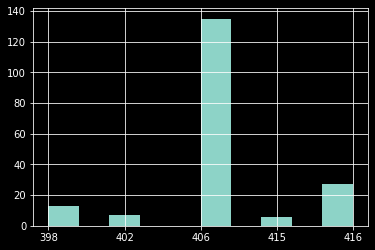

In [14]:
# check detection distribution
details = pred_details['Random Forest']
details[(details['pred'] > 0.8)].sort_values(by='subj')['subj'].hist()

In [30]:
# check detection distribution
details = pred_details['Random Forest']
details[(details['pred'] > 0.8)].sort_values(by='subj')['subj'].plot.pie()

TypeError: '<' not supported between instances of 'str' and 'int'

In [28]:
# check detection distribution
details = pred_details['LGBM']
unique, counts = np.unique(details[(details['pred'] > 0.8)].sort_values(by='subj')['subj'].to_numpy(), return_counts=True)
dict(zip(unique, counts))

{'398': 13, '402': 7, '406': 135, '415': 6, '416': 27}

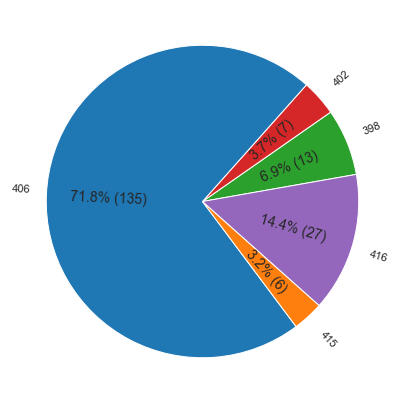

In [78]:
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(10,7))
#  = plt.pie(nonzero_spending['Sum'], labels=cat, radius=2, startangle=160,
#                                      autopct=lambda p: f"{p:.2f}%  ({p * sum(nonzero_spending['Sum']) / 100:,.0f})",
#                                      rotatelabels=True, pctdistance=0.5)

patches, labels, pct_texts = plt.pie(counts, labels=unique,  rotatelabels=True, startangle=10, colors=['tab:green','tab:red', 'tab:blue','tab:orange', 'tab:purple'], 
                                     autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()))

for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})

days = details[(details['pred'] > 0.8)].sort_values(by='subj').groupby('subj').size()
    
sns.set()
days.plot(kind='pie', title='Number of parties on different days',  rotatelabels=True, figsize=[8,8],
          autopct=lambda p: '{:.1f}%({:.0f})'.format(p,(p/100)*days.sum()), fontsize=14)

plt.show()

In [ ]:
days.plot(kind='pie', title='Number of parties on different days',  rotatelabels=True, figsize=[8,8],
          autopct=lambda p: '{:.1f}%({:.0f})'.format(p,(p/100)*days.sum()))

In [ ]:
details[(details['pred'] > 0.8)].sort_values(by='subj')['subj']

In [136]:
# TODO: check why its always LGBM results!!!!!!!!!!!!
details[(details['pred'] > 0.8)].sort_values(by='subj')

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,...,at_pmin_norm_2,gt_pmin_norm_2,ft_pmin_norm_2,ag_pmin_norm_2,af_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
97304,38,97304,0.0000074927,0.0000110640,-0.2401809763,-0.6616114037,3,0.0628107032,2.1964572063,0.3066889497,...,0.2484994213,-0.0815633262,-0.1147020012,-0.0976165261,-0.1627905729,1.5140582055,0.1512633938,-0.4684584650,0.1271129542,1.0
76754,38,76754,0.0000081495,0.0000131287,-0.7024768235,-0.8417677507,3,0.0637083663,2.2284174094,0.3185052298,...,0.0335774074,0.0285112243,0.0758459039,-0.0244433676,-0.0269518669,0.6656885752,-0.1604311457,-0.3893215098,-0.1782531480,1.0
81789,38,81789,0.0000083452,0.0000099413,-0.1552546975,0.0550255949,4,0.0938094790,2.4760067375,0.4199942571,...,-0.0267188088,-0.0107209110,-0.1696967700,0.0012076090,-0.1802860498,2.6021258560,-0.3872581529,-0.2039243865,-0.3948408886,1.0
29457,38,29457,0.0000083800,0.0000149435,-0.5202462607,-1.1455612352,6,0.0559912591,2.6227914727,0.3173467132,...,0.3878175896,-0.0324924973,0.3438454422,-0.0911169120,-0.0663423698,2.6145945869,0.0137087849,-0.3148226383,0.0366857624,1.0
29209,38,29209,0.0000035326,0.0000059051,-0.2471957389,-0.7800274210,8,0.1093921358,1.8182051427,0.1430322960,...,-0.1581268161,-0.0846889232,-0.1566385253,-0.0802124107,-0.1503521004,1.2919873250,-0.0542947382,-0.3026649504,-0.0628379765,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721321,416,97883,0.0000762893,0.0001320659,-0.3306474399,-1.0260596839,3,0.0303910993,1.8622314964,0.6338153843,...,-0.1724785710,-0.1168509375,-0.1384406799,-0.1225872666,-0.1356265639,3.0907330079,-0.4288443127,-0.6198485345,-0.3647386106,1.0
673943,416,50505,0.0000726453,0.0000917371,-0.6102664597,-0.6399849878,3,0.0442889712,1.3298975828,0.5948791160,...,-0.1210625654,-0.1090290497,-0.1473487509,-0.1125712849,-0.1630746846,3.5952070099,-0.4718581123,-0.6080063639,-0.3832293133,1.0
726995,416,103557,0.0000982789,0.0001637512,-0.7085319849,-0.9725307158,2,0.0316524548,1.4965275069,0.7362012147,...,-0.2374694271,-0.1143345690,-0.1501745191,-0.1187755441,-0.1733879774,9.3422110403,-0.9923462894,-0.7396215943,-0.6571291413,1.0
697765,416,74327,0.0000621858,0.0001029926,-0.5674986275,-0.8301006118,2,0.0312172027,1.7344472264,0.6375864175,...,-0.1215140294,-0.1090712104,-0.1474988945,-0.1126182618,-0.1707840322,2.1715730374,-0.5602478703,-0.6279755482,-0.3745888478,1.0


In [13]:
metrics

{'accuracy': 0.9678614402917046,
 'precision': 0.9962638365679897,
 'recall': 0.9392452142206016,
 'f_score': 0.9843129282686749}

In [14]:
y_rf.sum()

136653.0

In [15]:
random_metrics = []
for i in range(0, 100000):
    np.random.shuffle(y_rf)
    cf_matrix = confusion_matrix(y_test, y_rf)
    random_metrics.append(get_metrics(cf_matrix))

In [44]:
len(random_metrics_e5)

100000

In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')

%matplotlib inline
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(inline_rc)

In [36]:
random_metrics_e5 = random_metrics[:100000]

In [16]:
joblib.dump(random_metrics, 'scalp_shuffle_oversample.pkl')

['scalp_shuffle_oversample.pkl']

In [18]:
precision_random = [x['precision'] for x in random_metrics]
# recall_random = [x['recall'] for x in random_metrics]
# accuracy_random = [x['accuracy'] for x in random_metrics]
# f_random = [x['f_score'] for x in random_metrics]

In [ ]:
# Final plots at the other notebook (playground)
plt.hist(precision_random)
precision_max = '{0:.2f}'.format(max(precision_random))
plt.title('scalp: max precision = {}'.format(precision_max))
plt.xlim(0, 1)

In [ ]:
plt.figure(figsize=(8,5))
x = np.array(precision_random)
plt.hist(precision_random, bins=15, edgecolor="black", color='tab:blue')
plt.xlim(0, 1)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(x.max(), color='green', linestyle='dashed', linewidth=1.5)
plt.axvline(0.99, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel('Precision', fontsize=14)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.2f}%'.format(x.mean() * 100))
plt.text(x.max()*1.1, max_ylim*0.7, 'Max: {:.2f}%'.format(x.max() * 100))
plt.text(x.max()*1.3, max_ylim*0.5, 'classifier: {:.2f}%'.format(99))

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(8,5))
model_lgbm = joblib.load('thesis_scalp_lgbm.pkl')
model_rf = joblib.load('thesis_scalp_rf.pkl')
testX, testy = X_test_data, y_test
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='LGBM (AUC = 0.11)', color='tab:blue')
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='RF (AUC = 0.13)', color='tab:orange')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(prop={'size': 14})
# show the plot
plt.show()

NameError: name 'X_test_data' is not defined

<Figure size 576x360 with 0 Axes>

Logistic: f1=0.967 auc=0.993
Logistic: f1=0.967 auc=0.999


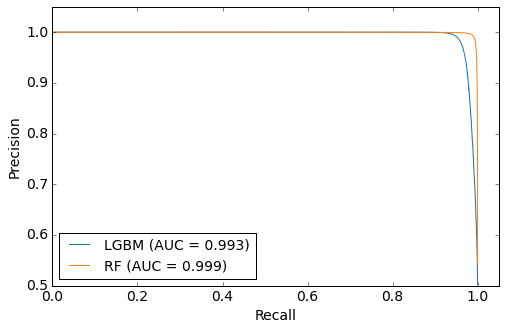

In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(8,5))
model_lgbm = classifiers_overlap["LGBM"]
model_rf = classifiers_overlap['Random Forest']
testX, testy = X_test_data, y_test
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='LGBM (AUC = 0.993)', color='tab:blue')
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.plot(lr_recall, lr_precision, label='RF (AUC = 0.999)', color='tab:orange')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.gca().set_ylim([0.5, 1.05])
plt.gca().set_xlim([0, 1.05])
# show the legend
plt.legend(loc=3, prop={'size': 14})
# show the plot
plt.show()

In [41]:
testX, testy = X_test_data, y_test
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.002 auc=0.130
Logistic: f1=0.002 auc=0.112


In [49]:
imp.head(30)

,0,imp
61,AH1-AH2_abspow_cmin_norm,0.0927461876
23,abspow_cmin_norm,0.0743821079
47,AH1-AH2_std_cmin_norm,0.0629714676
63,AH1-AH2_std_pmin_norm,0.0354071212
75,AH1-AH2_abspow_pmin_norm,0.0323411597
25,std_pmin_norm,0.0315685053
8,std_cmin_norm,0.0302244825
99,A1_abspow_cmin_norm,0.0273783518
38,abspow_pmin_norm,0.0247077445
51,AH1-AH2_hcomp_cmin_norm,0.0227156142


In [21]:
# leave one out section
subjects = ['398', '402', '406', '415', '416']
y_all_bi = get_all_y_multi_channel(subjects=subjects)
clear_output()
feat_avg = get_all_feat_avg_channels(subjects=subjects)
feat_all_eog2 = get_all_feat_eog('2', subjects=subjects)
clear_output()
feat_avg.reset_index(inplace=True, drop=True)
feat_all_eog2.reset_index(inplace=True, drop=True)
feat_eog2_avg = pd.concat([feat_avg, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

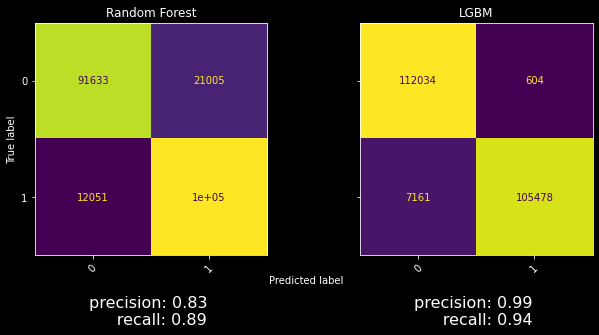

In [22]:
cls_over_loo = {
    "Random Forest": RandomForestClassifier(max_depth=10),
    "LGBM": LGBMClassifier(),
}

f, axes = plt.subplots(1, len(cls_over_loo), figsize=(10, 5), sharey='row')

oversample = SMOTE()
x_over, y_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, stratify=y_over, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

for i, (key, classifier) in enumerate(cls_over_loo.items()):
    y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        y_lgbm = y_pred
    else:
        y_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

In [23]:
# metrics for out subject
y_396 = get_all_y_multi_channel(subjects=['396'])
feat_avg_396 = get_all_feat_avg_channels(subjects=['396'])
feat_eog2_396 = get_all_feat_eog('2', subjects=['396'])
clear_output()
feat_eog2_avg_396 = pd.concat([feat_avg_396, feat_eog2_396.iloc[:, 2:].add_suffix('_2')], axis=1)

ipynb.fs.defs.yasa_model:94: RuntimeWarning: invalid value encountered in double_scalars


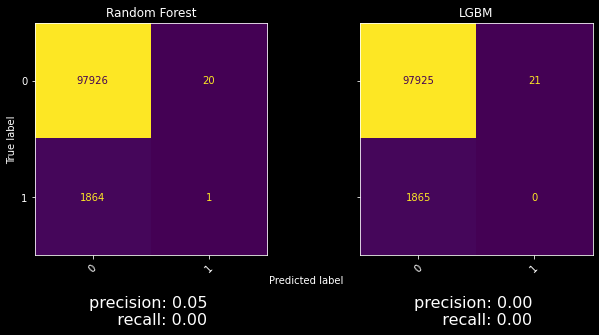

In [24]:
# results top 30
f, axes = plt.subplots(1, len(cls_over_loo), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_396.iloc[:, 2:]
feat_396_data = feat_396_data[cls_over_loo['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_over_loo.items()):
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[20]
    cf_matrix = confusion_matrix(y_396,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

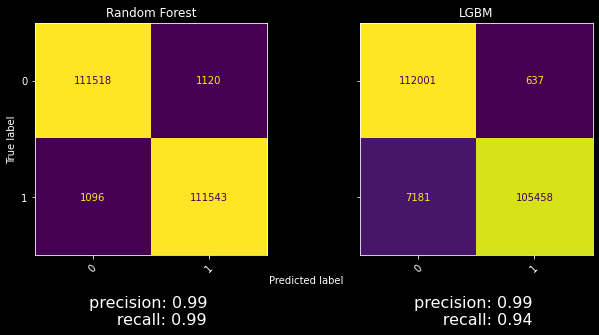

In [25]:
# default depth
cls_over_loo = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

f, axes = plt.subplots(1, len(cls_over_loo), figsize=(10, 5), sharey='row')

oversample = SMOTE()
x_over, y_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, stratify=y_over, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

for i, (key, classifier) in enumerate(cls_over_loo.items()):
    y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        y_lgbm = y_pred
    else:
        y_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

ipynb.fs.defs.yasa_model:94: RuntimeWarning: invalid value encountered in double_scalars


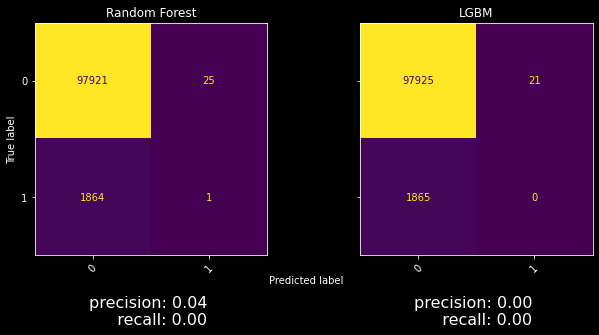

In [26]:
# results top 30
f, axes = plt.subplots(1, len(cls_over_loo), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_396.iloc[:, 2:]
feat_396_data = feat_396_data[cls_over_loo['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_over_loo.items()):
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[20]
    cf_matrix = confusion_matrix(y_396,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [12]:
# sanity check fast balance
feat_data = feat_eog2_avg_fast.iloc[:, 2:]
feat_data = feat_data[cls_all_balance['LGBM'].feature_name_]
y_try = cls_all_balance["Random Forest"].predict(feat_data)
y_try.sum()

8961.0

In [13]:
# metrics for out subject
y_396_fast = get_all_y_multi_channel(subjects=['398'])
feat_avg_396_fast = get_all_feat_avg_channels(subjects=['398'])
feat_eog2_396_fast = get_all_feat_eog('2', subjects=['398'])
clear_output()
feat_eog2_avg_396_fast = pd.concat([feat_avg_396_fast, feat_eog2_396_fast.iloc[:, 2:].add_suffix('_2')], axis=1)

In [16]:
# get everyone feat and y
feat_by_subj = []
feat_dict = {}
y_by_subj = []
y_dict = {}
for subj in ['396', '398', '402', '406', '415', '416']:
    y_396_fast = get_all_y_multi_channel(subjects=[subj])
    y_by_subj.append(y_396_fast)
    y_dict[subj] = y_396_fast
    feat_avg_396_fast = get_all_feat_avg_channels(subjects=[subj])
    feat_eog2_396_fast = get_all_feat_eog('2', subjects=[subj])
    clear_output()
    feat_eog2_avg_396_fast = pd.concat([feat_avg_396_fast, feat_eog2_396_fast.iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_by_subj.append(feat_eog2_avg_396_fast)
    feat_dict[subj] = feat_eog2_avg_396_fast

In [17]:
joblib.dump(feat_by_subj, 'feat_by_subj.pkl')
joblib.dump(feat_dict, 'feat_dict.pkl')
joblib.dump(y_by_subj, 'y_by_subj.pkl')
joblib.dump(y_dict, 'y_dict.pkl')

['y_dict.pkl']

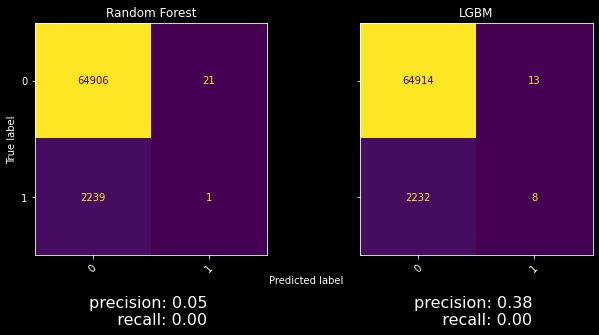

In [15]:
# simple model results top 30
f, axes = plt.subplots(1, len(cls_all_fast2), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_396_fast.iloc[:, 2:]
feat_396_data = feat_396_data[cls_all_fast2['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_fast2.items()):
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[20]
    cf_matrix = confusion_matrix(y_396_fast,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

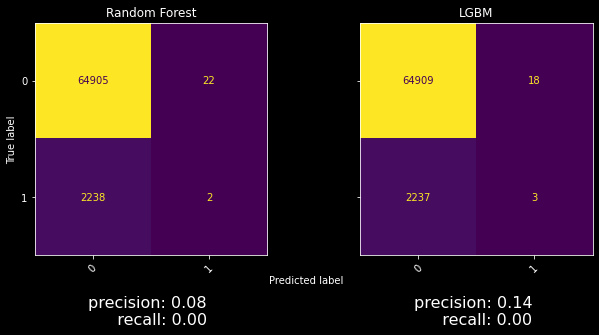

In [16]:
# over-sample model top 30
f, axes = plt.subplots(1, len(cls_all_balance), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_396_fast.iloc[:, 2:]
feat_396_data = feat_396_data[cls_all_balance['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_balance.items()):
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[20]
    cf_matrix = confusion_matrix(y_396_fast,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

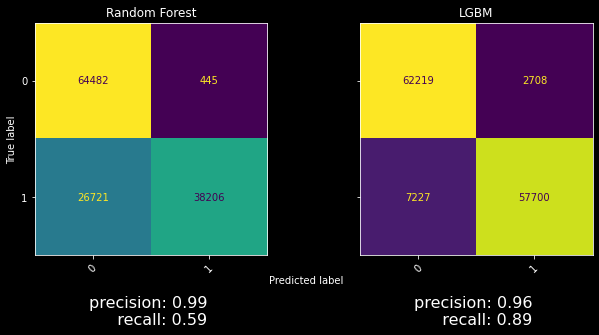

In [17]:
# over-sample subj
oversample = SMOTE()
feat_over, y_over = oversample.fit_resample(feat_eog2_avg_396_fast, y_396_fast)

f, axes = plt.subplots(1, len(cls_all_balance), figsize=(10, 5), sharey='row')

feat_396_data = feat_over.iloc[:, 2:]
feat_396_data = feat_396_data[cls_all_balance['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_balance.items()):
    y_pred = classifier.predict(feat_396_data)
    cf_matrix = confusion_matrix(y_over, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

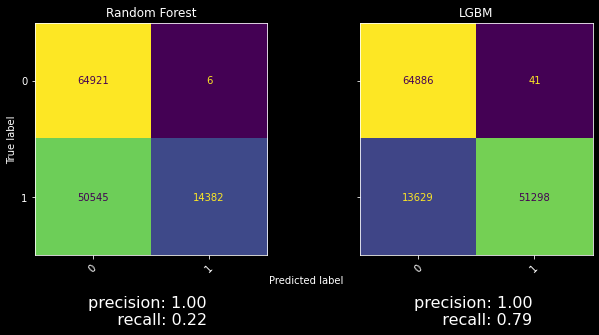

In [23]:
# over-sample subj prob 80
prob=0.8
f, axes = plt.subplots(1, len(cls_all_balance), figsize=(10, 5), sharey='row')

feat_396_data = feat_over.iloc[:, 2:]
feat_396_data = feat_396_data[cls_all_balance['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_balance.items()):
    y_pred = classifier.predict_proba(feat_396_data).T
    cf_matrix = confusion_matrix(y_over, [p > prob for p in y_pred[1]])
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
        y_pred_lgbm = y_pred
    else:
        y_pred_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

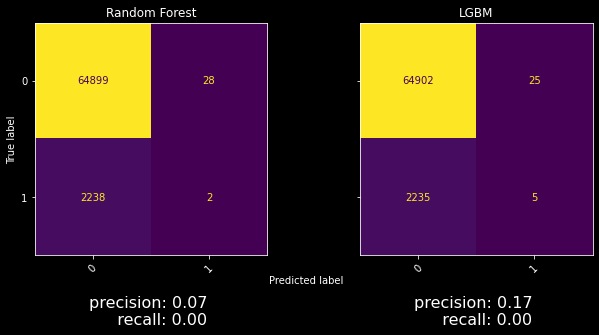

In [96]:
f, axes = plt.subplots(1, len(cls_all_fast2), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_396_fast.iloc[:, 2:]
feat_396_data = feat_396_data[cls_all_fast2['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_fast2.items()):
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[30]
    cf_matrix = confusion_matrix(y_396_fast,  [p > prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [88]:
np.sort(y_pred[1])[::-1].T

array([0.49026808, 0.4856692 , 0.46045651, ..., 0.00257861, 0.00228339,
       0.0018166 ])

[Text(0.4789496527777778, 0.9444444444444444, 'X[11] <= 0.025\ngini = 0.5\nsamples = 471668\nvalue = [373612, 372573]'),
 Text(0.2199074074074074, 0.8333333333333334, 'X[21] <= -0.121\ngini = 0.455\nsamples = 85277\nvalue = [87752, 47175]'),
 Text(0.1072048611111111, 0.7222222222222222, 'X[20] <= -0.168\ngini = 0.354\nsamples = 15526\nvalue = [18864, 5620]'),
 Text(0.046296296296296294, 0.6111111111111112, 'X[36] <= 4192.171\ngini = 0.48\nsamples = 1847\nvalue = [1758, 1169]'),
 Text(0.018518518518518517, 0.5, 'X[35] <= 0.0\ngini = 0.238\nsamples = 354\nvalue = [475, 76]'),
 Text(0.006944444444444444, 0.3888888888888889, 'X[11] <= 0.009\ngini = 0.398\nsamples = 114\nvalue = [127, 48]'),
 Text(0.004629629629629629, 0.2777777777777778, 'gini = 0.0\nsamples = 20\nvalue = [35, 0]'),
 Text(0.009259259259259259, 0.2777777777777778, 'X[14] <= 2.347\ngini = 0.451\nsamples = 94\nvalue = [92, 48]'),
 Text(0.004629629629629629, 0.16666666666666666, 'X[36] <= 3324.154\ngini = 0.358\nsamples = 71\n

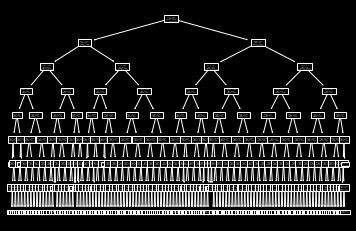

In [39]:
from sklearn.tree import plot_tree

plot_tree(cls_all_balance["Random Forest"].estimators_[0])

,0,imp
20,fast_cmin_norm_2,0.0134583369
0,skew_2,0.0127251303
29,abspow_cmin_norm_2,0.0117167907
27,bf_cmin_norm_2,0.0116435138
80,sf_cmin_norm_c3,0.0115823173
26,sf_cmin_norm_2,0.0114795171
9,bf_2,0.0114475152
3,hcomp_2,0.0113479653
16,hcomp_cmin_norm_2,0.0111919083
31,higuchi_cmin_norm_2,0.0110421177


,0,imp
66,gf_2,76
105,gf_pmin_norm_2,73
28,bf_cmin_norm,61
11,gf,58
10,bf,58
39,hcomp_pmin_norm,57
59,hcomp_2,57
9,sf,57
72,hcomp_cmin_norm_2,56
56,skew_2,54


In [ ]:
imp = pd.DataFrame(cls_all['LGBM'].feature_name_)
imp['imp'] = cls_all["LGBM"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

In [ ]:
imp = pd.DataFrame(cls_all_12['LGBM'].feature_name_)
imp['imp'] = cls_all_12["LGBM"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(20)

In [9]:
subjects = ['396', '402', '406', '415', '416']
feat_avg_new = get_all_feat_avg_channels(subjects=subjects)
feat_all_eog2_new = get_all_feat_eog('2', subjects=subjects)
clear_output()
feat_eog2_avg_new = pd.concat([feat_avg_new, feat_all_eog2_new.iloc[:, 2:].add_suffix('_2')], axis=1)

In [10]:
feat_avg_396_new = get_all_feat_avg_channels(subjects=['398'])
feat_eog2_396_new = get_all_feat_eog('2', subjects=['398'])
clear_output()
feat_eog2_avg_396 = pd.concat([feat_avg_396_new, feat_eog2_396_new.iloc[:, 2:].add_suffix('_2')], axis=1)

In [ ]:
y_all_bi = get_all_y_multi_channel(subjects=subjects)
y_396 = get_all_y_multi_channel(subjects=['398'])
clear_output()
cls_all, pred_details = plt_cls(feat_eog2_avg_new, y_all_bi, stratify=True)

In [18]:
imp = pd.DataFrame(cls_all['LGBM'].feature_name_)
imp['imp'] = cls_all["Random Forest"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(20)

,0,imp
10,sf_cmin_norm,0.0778408220
13,abspow_cmin_norm,0.0635889002
30,abspow_cmin_norm_2,0.0602879116
5,sf,0.0595316556
20,hcomp_2,0.0446756419
26,ag_cmin_norm_2,0.0441525952
25,abspow_2,0.0422440379
35,gf_pmin_norm_2,0.0409952709
27,sf_cmin_norm_2,0.0396580261
17,gf_pmin_norm,0.0341667186


In [19]:
# sanity check
feat_data = feat_eog2_avg_new.iloc[:, 2:]
feat_data = feat_data[cls_all['LGBM'].feature_name_]
y_try = cls_all["Random Forest"].predict(feat_data)
y_try.sum()

146.0

In [21]:
len(cls_all['LGBM'].feature_name_)

37

In [ ]:
feat_eog2_avg_396_fast

In [ ]:
feat_over

In [ ]:
y_pred_rf.T[:67167]

ipynb.fs.defs.yasa_model:94: RuntimeWarning: invalid value encountered in double_scalars


IndexError: invalid index to scalar variable.

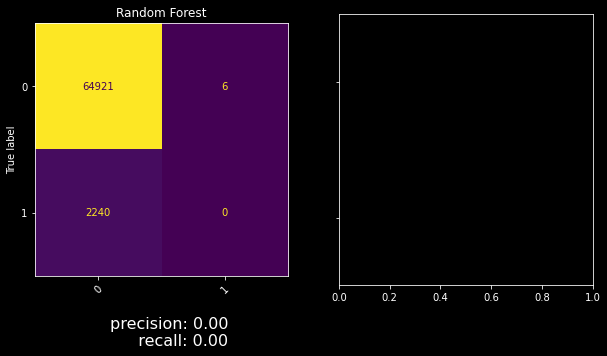

In [40]:
# over-sample subj prob 80
prob=0.8
f, axes = plt.subplots(1, len(cls_all_balance), figsize=(10, 5), sharey='row')

# feat_396_data = feat_over.iloc[:, 2:]
# feat_396_data = feat_396_data[cls_all_balance['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_all_balance.items()):
    # y_pred = classifier.predict_proba(feat_396_data).T
    y_pred = y_pred_rf[1].T[:67167]
    cf_matrix = confusion_matrix(y_396_fast, [p > prob for p in y_pred])
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
        y_pred_lgbm = y_pred
    else:
        y_pred_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

KeyboardInterrupt: 

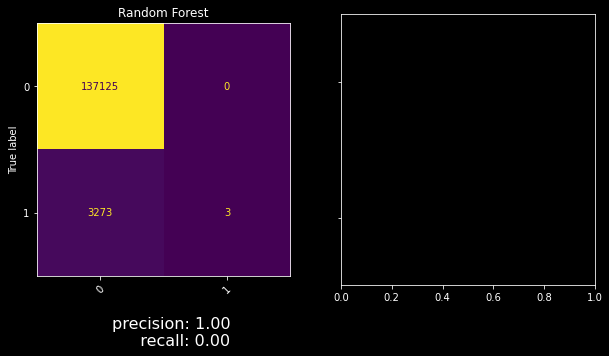

In [29]:
cls, feat, y, prob = cls_all, feat_eog2_avg, y_all_bi, 0.85
X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')
pred_details = {}

for i, (key, classifier) in enumerate(cls.items()):
    y_pred = classifier.predict_proba(X_test_data).T
    cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                          recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details